# Digitize image of SSC covariance

Reference: Barreira, Krause & Schmidt, http://arxiv.org/abs1711.07467

In [88]:
import cv2
from scipy import interpolate
from matplotlib import cm
%matplotlib inline

Read image

In [166]:
dat = cv2.imread('fig_cov_l1l2_maps.png', -1)

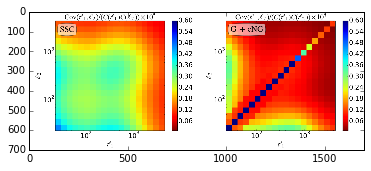

In [167]:
ax = plt.imshow(dat)

Cut out left panel, SSC covariance

In [168]:
lower_x = 139
lower_y =  55
upper_x = 679
upper_y = 595

In [186]:
cov_fine = dat[lower_y : upper_y, lower_x : upper_x]

Invert x-axis such that lower left image corner is (0,0).

In [187]:
cov_fine = cov_fine[::-1,:,:]

Plot with new axis direction accounted for, origin at lower left corner

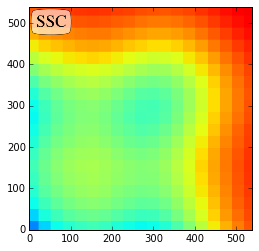

In [188]:
ax = plt.imshow(cov_fine, cmap=cm.jet, origin='lower')

In [194]:
import scipy.cluster.vq as scv
def colormap2arr(arr,cmap,N=100):    
    # http://stackoverflow.com/questions/3720840/how-to-reverse-color-map-image-to-scalar-values/3722674#3722674
    gradient=cmap(np.linspace(0.0, 1.0, N)) #[:, 0:3]

    # Reshape arr to something like (240*240, 4), all the 4-tuples in a long list...
    arr2=arr.reshape((arr.shape[0]*arr.shape[1],arr.shape[2]))

    # Use vector quantization to shift the values in arr2 to the nearest point in
    # the code book (gradient).
    code,dist=scv.vq(arr2,gradient)

    # code is an array of length arr2 (240*240), holding the code book index for
    # each observation. (arr2 are the "observations".)
    # Scale the values so they are from 0 to 1.
    values=code.astype('float')/gradient.shape[0]

    # Reshape values back to (240,240)
    values=values.reshape(arr.shape[0],arr.shape[1])
    values=values[::-1, ::-1]
    return values

Transform RGB tuple to scalar

In [195]:
cov_sc = colormap2arr(cov_fine, cm.jet, N=300)
#cov_sc = cov_fine

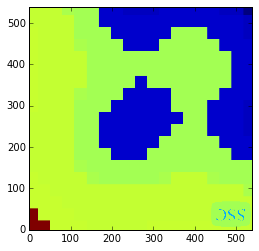

In [196]:
ax = plt.imshow(cov_sc, origin='lower')

Remap to original image pixels in $\ell$.

In [207]:
npix = 19
n = upper_x - lower_x
step = int(n / npix)
cov = cov_sc[0:n:step,0:n:step]

Copy upper left to lower right triangle, to overwrite plot legend

In [208]:
i_upper = np.triu_indices(npix+1, -1)
cov[i_upper] = cov.T[i_upper]

Last pixel is mapped to wrong value, change it by hand

In [253]:
cov[npix, npix] = cov[npix-1, npix-1]

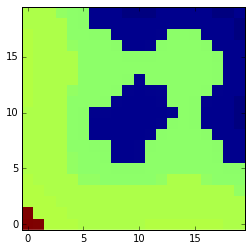

In [254]:
ax = plt.imshow(cov, interpolation='none', origin='lower')

Cut out color legend from image

In [255]:
x_leg = 730
lower_y_leg = 54 + 10
upper_y_leg = 590 - 10
n_leg = upper_y_leg - lower_y_leg

In [256]:
leg_fine = dat[lower_y_leg : upper_y_leg, (x_leg-1):(x_leg+1)]

In [257]:
leg_sc = colormap2arr(leg_fine, cm.jet, N=50)
#leg_sc = leg_fine

In [258]:
step = 70
leg = leg_sc[0:n_leg:step, :]
leg = leg[::-1,:]

array([ 0.12,  0.34,  0.36,  0.38,  0.62,  0.64,  0.66,  0.86])

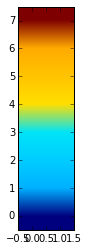

In [259]:
plt.imshow(leg, origin='lower')
leg0 = leg[:,0]
leg0

Map colors to values according to legend labels, and create interpolation object

In [260]:
v0 = 0
v1 = 0.6
v = np.linspace(v0, v1, len(leg0))
leg_interp = interpolate.interp1d(leg0, v, kind='linear', bounds_error=False, fill_value=0)

In [261]:
my_v = leg_interp(0.2)
my_v

array(0.031168831168831172)

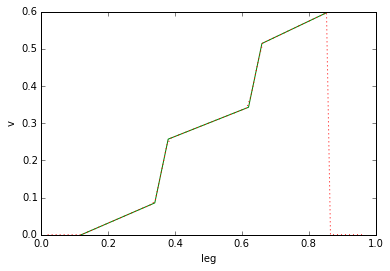

In [262]:
plt.plot(leg0, v, 'g-')
leg0_10 = np.linspace(leg0[0]-0.1, leg0[-1]+0.1, len(leg0)*10)
plt.plot(leg0_10, leg_interp(leg0_10), 'r:')
plt.ylabel('v')
plt.xlabel('leg')

Create matrix with real (covariance) values according

In [263]:
cov_v = []
for i in range(cov.shape[0]):
    row = leg_interp(cov[:,i])
    cov_v.append(row)
cov_v = np.array(cov_v)

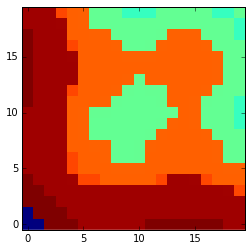

In [264]:
ax = plt.imshow(cov_v, interpolation='none', origin='lower')

In [265]:
np.diag(cov_v)

array([ 0.        ,  0.51428571,  0.51428571,  0.5       ,  0.5       ,
        0.41428571,  0.41428571,  0.41428571,  0.24285714,  0.24285714,
        0.24285714,  0.24285714,  0.24285714,  0.41428571,  0.41428571,
        0.41428571,  0.41428571,  0.24285714,  0.24285714,  0.24285714])

In [266]:
x1, x2 = np.mgrid[0:npix+1:1, 0:npix+1:1]
grid   = np.dstack((x1, x2))

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


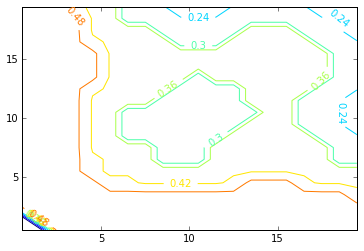

In [287]:
fig, ax = plt.subplots()
CS = ax.contour(cov_v, levels=[0.06, 0.12, 0.18, 0.24, 0.3, 0.36, 0.42, 0.48, 0.54, 0.6], cmap=cm.jet, origin='lower')
CS.levels = [val for val in CS.levels]
txt = ax.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=10)